# How to use pysigproc to generate candidates

In [2]:
import h5plotter
from candidate import Candidate

In [3]:
import numpy as np
from scipy.signal import detrend
import pylab as plt
import logging
logger = logging.getLogger()
logger = logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(threadName)s - %(levelname)s -'
                                                        ' %(message)s')

In [4]:
# creating the candidate object with a certain dm, label, snr, tcand and width
cand = Candidate(fp=f'/home/suyash/FRB_DM100_163.84us_4K_16mP_1msW_10sig.header.fil', dm=1000, label=1, snr=40, tcand=400, width=1**1)

In [5]:
# Get data, this will take data from the filterbank file, and can be accessed from cand.data:
cand.get_chunk()
print(cand.data, cand.data.shape,cand.dtype)

[[134 129 112 ...  95 133 107]
 [ 80 123  91 ...  83  99 163]
 [135 125 164 ... 102 197 128]
 ...
 [187 113 132 ... 177 160 129]
 [144 105 121 ...  67  73 141]
 [117 138 122 ... 134 129 119]] (360028, 4096) <class 'numpy.uint8'>


In [6]:
# Now let's make the DM Time plot. This may take a while. 
cand.dmtime()

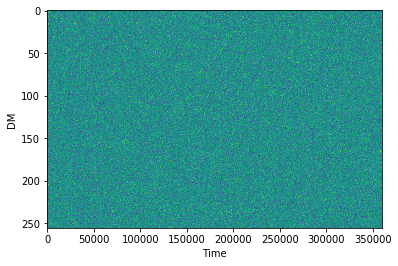

In [7]:
# the DM time plot can be accessed using cand.dmt. Let's have a look: 
plt.imshow(cand.dmt, aspect='auto',interpolation=None)
plt.ylabel('DM')
plt.xlabel('Time')
plt.show()

In [8]:
# Now let's Dedisperse it!
cand.dedisperse()

MemoryError: 

In [9]:
# The dedispersed pulse can be obtained using cand.dedispersed
plt.imshow(cand.dedispersed.T,aspect='auto',interpolation=None)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

AttributeError: 'NoneType' object has no attribute 'T'

In [10]:
# Detrending can be used to remove bandpass variations
plt.imshow(detrend(cand.dedispersed.T),aspect='auto',interpolation=None)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

AttributeError: 'NoneType' object has no attribute 'T'

In [11]:
# Optimise dm could be used to obtain accurate value of dm, and snr at that dm (under testing)
cand.optimize_dm()
print(f'Heimdall reported dm: {cand.dm}, Optimised DM: {cand.dm_opt}')
print(f'Heimdall reported snr: {cand.snr}, SNR at Opt. DM: {cand.snr_opt}')

Heimdall reported dm: 1000, Optimised DM: 980.2665740630362
Heimdall reported snr: 40, SNR at Opt. DM: 5.614308834075928


In [12]:
# for now, let's enter some random values for dm_opt and snr_opt
cand.dm_opt = -1
cand.snr_opt = -1

In [13]:
# Name of the candidate
cand.id

'cand_tstart_58017.599681826483_tcand_400.0000000_dm_1000.00000_snr_40.00000'

In [14]:
# Now let's save our candidate in an h5
fout=cand.save_h5()
print(fout) 

AttributeError: 'NoneType' object has no attribute 'dtype'

In [15]:
# We will use h5plotter to plot the candidate h5 we just generated
h5plotter.plot_h5(fout, show=True, detrend=False, save=False)

NameError: name 'fout' is not defined

# Reshaping Freq-time and DM-time arrays

In [ ]:
dedispersed_bkup = cand.dedispersed
dmt_bkup = cand.dmt

In [ ]:
print(f'Shape of dedispersed (frequency-time) data: {dedispersed_bkup.T.shape}')
print(f'Shape of DM-time data: {dmt_bkup.shape}')

In [ ]:
time_size = 256
freq_size = 256

# Using resize in skimage.transform for reshaping

In [ ]:
#resize dedispersed Frequency-time array along time axis
cand.resize(key='ft', size=time_size, axis=0, anti_aliasing=True)

#resize dedispersed Frequency-time array along time axis
cand.resize(key='ft', size=freq_size, axis=1, anti_aliasing=True)
logging.info(f'Resized Frequency-Time data to fsize: {freq_size} and tsize: {time_size}')

print(f'Shape of dedispersed (frequency-time) data: {cand.dedispersed.T.shape}')

In [ ]:
#resize DM-time array along time axis
cand.resize(key='dmt', size = time_size, axis=1, anti_aliasing=True)
logging.info(f'Resized DM-Time to dmsize: 256 and tsize: {time_size}')
print(f'Shape of DM-time data: {cand.dmt.shape}')

# Using decimate for reshaping

In [ ]:
from candidate import crop

In [ ]:
cand.dedispersed = dedispersed_bkup
cand.dmt = dmt_bkup

In [ ]:
# Let's use pulse width to decide the decimate factor by which to collape the time axis
pulse_width = cand.width
if pulse_width == 1:
    time_decimate_factor = 1
else:
    time_decimate_factor = pulse_width // 2  

# Decimating time axis, and cropping to the final size
cand.decimate(key='ft', axis=0, pad=True, decimate_factor=time_decimate_factor, mode='median')
crop_start_sample_ft = cand.dedispersed.shape[0] // 2 - time_size // 2
cand.dedispersed = crop(cand.dedispersed, crop_start_sample_ft, time_size, 0)

# Decimating frequency axis
cand.decimate(key='ft', axis=1, pad=True, decimate_factor=cand.dedispersed.shape[1]//freq_size, mode='median')
logging.info(f'Decimated Frequency-Time data to fsize: {freq_size} and tsize: {time_size}')

print(f'Shape of dedispersed (frequency-time) data: {cand.dedispersed.T.shape}')

In [ ]:
# Reshaping the DM-time using decimation
# Decimating time axis and croppig to the final required size 
cand.decimate(key='dmt', axis=1, pad=True, decimate_factor=time_decimate_factor, mode='median')
crop_start_sample_dmt = cand.dmt.shape[1] // 2 - time_size // 2
cand.dmt = crop(cand.dmt, crop_start_sample_dmt, time_size, 1)
logging.info(f'Decimated DM-Time to dmsize: 256 and tsize: {time_size}')
print(f'Shape of DM-time data: {cand.dmt.shape}')

In [ ]:
# here is our dispersed pulse
plt.imshow(cand.data.T,aspect='auto',interpolation=None)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()